In [1]:
import pandas as pd
import numpy as np
import pymongo 
from pymongo import MongoClient
import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_data(mongodb_client, database_name, collection_name):
    """ Reading scrapped reviews from MongoDB """
    # Creating list to store customer reviews
    customer_reviews = []

    # Initialize database 
    db = mongodb_client[database_name]
    collection = db[collection_name]

    # Reading collection
    for document in collection.find():
        if len(document) > 5: # Indicating that all the required keys are present in the dictionary
            customer_reviews.append(document)
        continue

    return pd.DataFrame(customer_reviews)

In [3]:
# Reading documents from MongoDB
total_df = read_data(
    mongodb_client = MongoClient("mongodb://localhost:27017/"), 
    database_name = 'TrustPilotDatabase', collection_name = 'ReviewCollection'
)

# Filtering reviews on the basis of attributes which were found 
reviews_df = total_df[
    (total_df['Username']!='NOT FOUND') & (total_df['Location']!='NOT FOUND') & 
    (total_df['Review']!='NOT FOUND') & (total_df['Rating']!='NOT FOUND') &
    (total_df['Title']!='NOT FOUND')
].reset_index(drop=True)

## Exploratory Data Analysis

In [4]:
import nltk 
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from itertools import chain
import string 
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

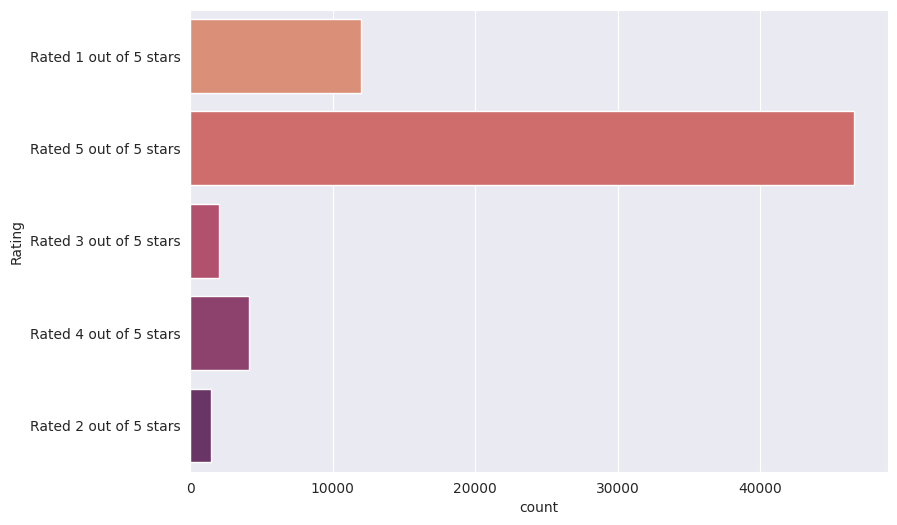

In [5]:
# Checking Class Distribution
with sn.axes_style("darkgrid"):
    fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(9,6))
    ax = sn.countplot(reviews_df['Rating'], palette = "flare", legend=False)

In [6]:
def split_rating_string(input_string):
    """ Function to split input string into integer ratings """
    if int(input_string.split(' ')[1]) in [1,2,3]:
        return 'Negative'
    return 'Positive'

reviews_df['ProcessedRating'] = reviews_df['Rating'].map(lambda x: split_rating_string(x), na_action='ignore')

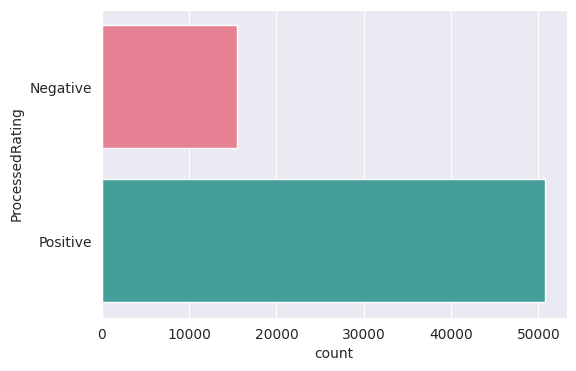

In [7]:
# Checking Class Distribution
with sn.axes_style("darkgrid"):
    fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(6,4))
    ax = sn.countplot(reviews_df['ProcessedRating'], palette = "husl", legend=False)

Character length - 68 percentile : 166.0
Character length - 95 percentile : 512.0
Character length - 99.7 percentile : 1375.0

Token length - 68 percentile : 30.0
Token length - 95 percentile : 94.0
Token length - 99.7 percentile : 255.0


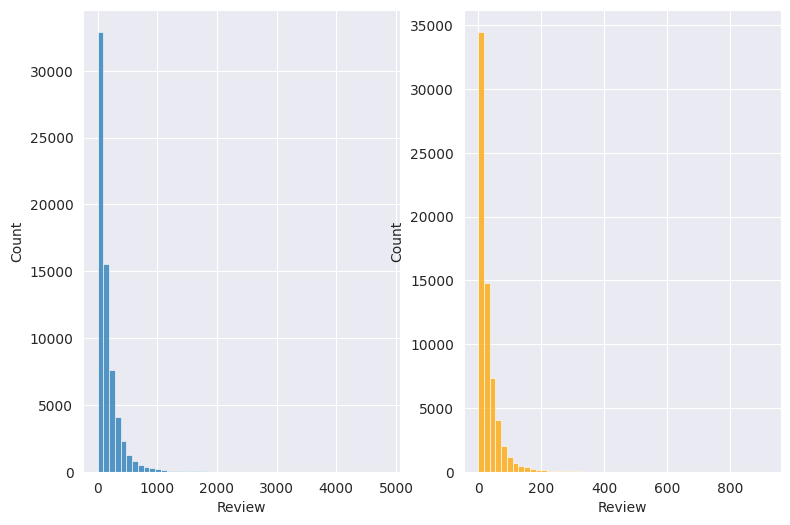

In [8]:
## Extracting character length of review corpus
sent_char_length = reviews_df['Review'].str.len()
print(f'Character length - 68 percentile : {np.percentile(sent_char_length, 68)}')
print(f'Character length - 95 percentile : {np.percentile(sent_char_length, 95)}')
print(f'Character length - 99.7 percentile : {np.round(np.percentile(sent_char_length, 99.7))}')
print()

## Extracting token length of review corpus
sent_token_length = reviews_df['Review'].str.split().apply(lambda x: len(x))
print(f'Token length - 68 percentile : {np.percentile(sent_token_length, 68)}')
print(f'Token length - 95 percentile : {np.percentile(sent_token_length, 95)}')
print(f'Token length - 99.7 percentile : {np.round(np.percentile(sent_token_length, 99.7))}')

# Character-length distribution
with sn.axes_style("darkgrid"):
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(9,6))
    ax0 = sn.histplot(sent_char_length , ax=ax0,bins=50);
    ax1 = sn.histplot(sent_token_length , ax=ax1,bins=50, color = "orange");

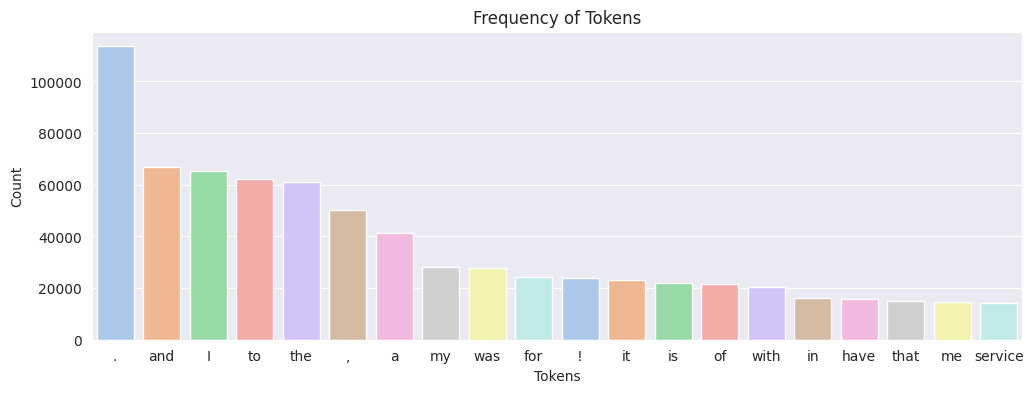

In [9]:
tokens =[]
for review in reviews_df['Review']:
    words = word_tokenize(review)
    tokens.append(words)

# Most frequently occuring tokens
tokens = list(chain.from_iterable(tokens))
common_20 = Counter(tokens).most_common(20)
common_20_tokens = []
common_20_values = []

for i in range(len(common_20)):
    common_20_tokens.append(common_20[i][0])
    common_20_values.append(common_20[i][1])

# Plotting
with sn.axes_style("darkgrid"):
    fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(12,4))
    ax = sn.barplot(x = common_20_tokens , y = common_20_values, palette = "pastel", legend = True)
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Count')
    ax.set_title('Frequency of Tokens')

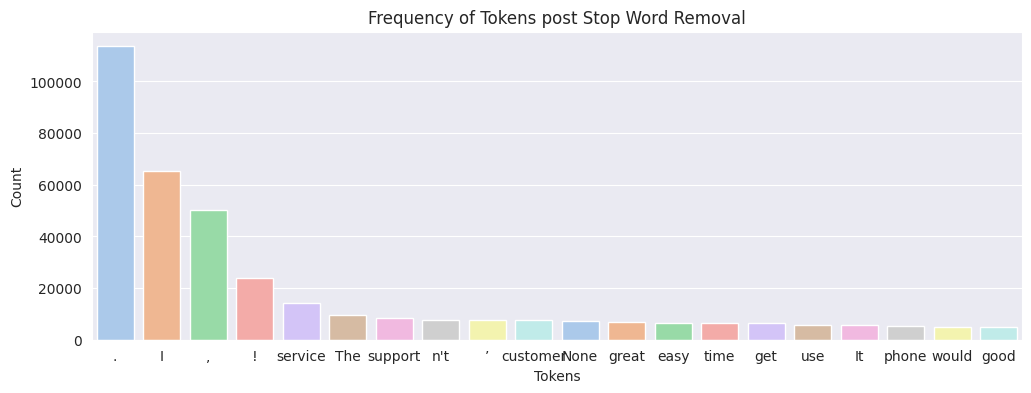

In [10]:
# Removing stop words & checking once again
stopwords_removed = [word for word in tokens if word not in stop_words]

stopword_common_20 = Counter(stopwords_removed).most_common(20)
common_20_tokens = []
common_20_values = []

for i in range(len(common_20)):
    common_20_tokens.append(stopword_common_20[i][0])
    common_20_values.append(stopword_common_20[i][1])

# Plotting
with sn.axes_style("darkgrid"):
    fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(12,4))
    ax = sn.barplot(x = common_20_tokens , y = common_20_values, palette = "pastel", legend = True)
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Count')
    ax.set_title('Frequency of Tokens post Stop Word Removal')

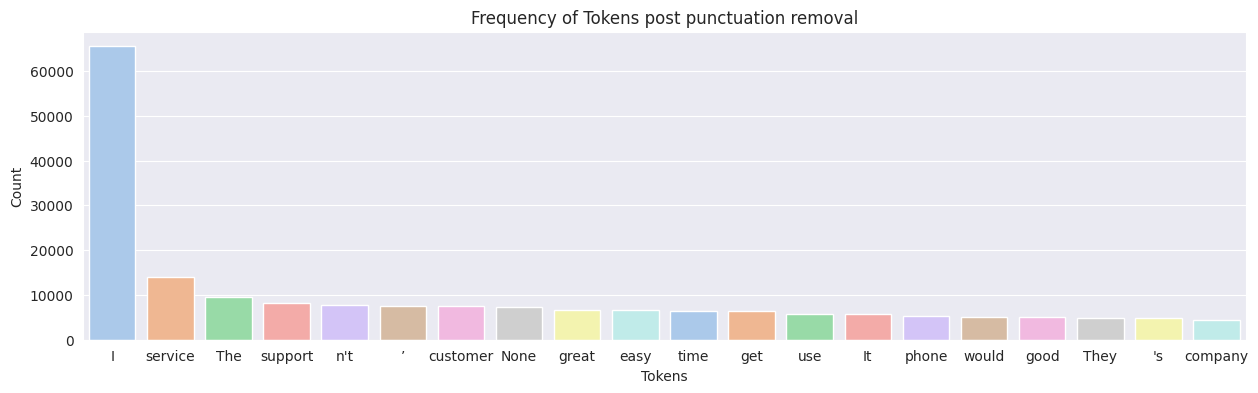

In [11]:
# Removing punctuations as well 
punctuation_removed = [word for word in stopwords_removed if word not in string.punctuation]

punctuation_common_20 = Counter(punctuation_removed).most_common(20)
common_20_tokens = []
common_20_values = []

for i in range(len(common_20)):
    common_20_tokens.append(punctuation_common_20[i][0])
    common_20_values.append(punctuation_common_20[i][1])

# Plotting
with sn.axes_style("darkgrid"):
    fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(15,4))
    ax = sn.barplot(x = common_20_tokens , y = common_20_values, palette = "pastel", legend = True)
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Count')
    ax.set_title('Frequency of Tokens post punctuation removal')

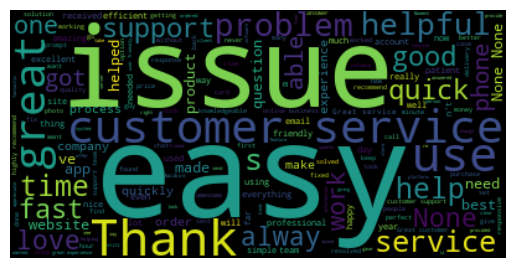

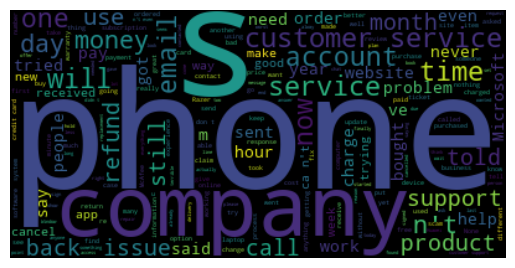

In [12]:
# Visualizing frequency of tokens by class in a wordcloud
# Negative tokens
negative_tokens =[]
negative_reviews = reviews_df[reviews_df['ProcessedRating'] == 'Negative'].reset_index(drop=True)['Review'].to_list()
for review in negative_reviews:
    words = word_tokenize(review)
    negative_tokens.append(words)
negative_tokens = list(chain.from_iterable(negative_tokens))
negative_string = ' '.join(negative_tokens)

# Positive tokens
positive_tokens =[]
positive_reviews = reviews_df[reviews_df['ProcessedRating'] == 'Positive'].reset_index(drop=True)['Review'].to_list()
for review in positive_reviews:
    words = word_tokenize(review)
    positive_tokens.append(words)
positive_tokens = list(chain.from_iterable(positive_tokens))
positive_string = ' '.join(positive_tokens)

# Visualizing wordclouds for positive & negative tokens
positive_wordcloud = WordCloud().generate(positive_string)
negative_wordcloud = WordCloud().generate(negative_string)

# Display the generated image:
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Display the generated image:
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
# Most frequently occuring N-Grams